In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

from datetime import date

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

import configparser
config = configparser.ConfigParser()
config.read('config.ini')

import wandb
wandb.login()

2.9.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mhrnciar (nsiete-hrnciar-katkovcin). Use `wandb login --relogin` to force relogin


True

In [2]:
name_of_run = 'wider-conv-layers-8-image-generator-penalization-200epoch-scheduler'

In [3]:
run = wandb.init(project="convolutional-nn", id=name_of_run)

In [4]:
EPOCHS = config['default'].getint('epochs')
IMAGE_SIZE = config['default'].getint('image_size')
BATCH_SIZE = config['default'].getint('batch_size')
SEED = config['default'].getint('seed')
START_LR = config['default'].getfloat('start_lr')
MAX_LR = config['default'].getfloat('max_lr')
STEPS_PER_EPOCH = config['default'].getint('steps_per_epoch')
ANNEAL_STRATEGY = config['default']['strategy']

wandb.config.update({'epochs': EPOCHS, 
                     'image_size': IMAGE_SIZE, 
                     'batch_size': BATCH_SIZE,
                     'start_lr': START_LR,
                     'max_lr': MAX_LR, 
                     'strategy': ANNEAL_STRATEGY})

In [5]:
data_path = 'Data/original'

class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)
print("Number of Classes:", num_classes)

class_sizes = []
for name in class_names:
    class_size = len(os.listdir(data_path + "/" + name))
    class_sizes.append(class_size)

print("Class Distribution:\n", dict(zip(class_names, class_sizes)))

Number of Classes: 10
Class Distribution:
 {'butterfly': 2112, 'cat': 1668, 'chicken': 3098, 'cow': 1866, 'dog': 4863, 'elephant': 1446, 'horse': 2623, 'sheep': 1820, 'spider': 4821, 'squirrel': 1862}


<AxesSubplot:title={'center':'Animal class distribution'}, ylabel='Animal'>

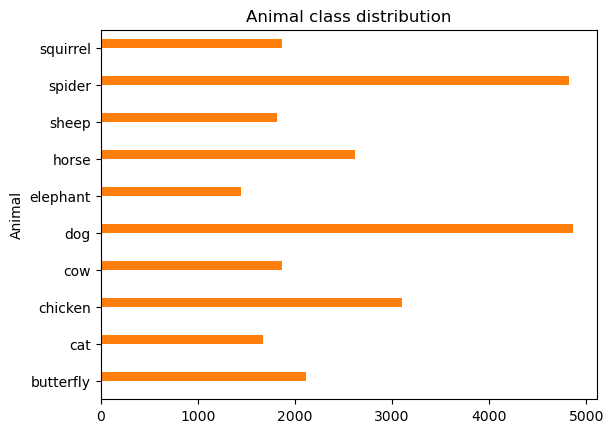

In [6]:
distribution = dict(zip(class_names, class_sizes))
distributionDf = pd.DataFrame.from_dict(distribution.items())
distributionDf.columns = ['Animal', 'Count']
distributionDf = distributionDf.reset_index()

distributionDf.plot.barh(x = 'Animal', title='Animal class distribution', legend = False)

In [7]:
distributionDf['Weight'] = distributionDf['Count'].sum() / distributionDf['Count']
distributionDf['Weight'] = distributionDf['Weight'] / distributionDf['Weight'].mean()
weights = distributionDf['Weight'].to_dict()

print(distributionDf)
weights

   index     Animal  Count    Weight
0      0  butterfly   2112  1.051237
1      1        cat   1668  1.331063
2      2    chicken   3098  0.716660
3      3        cow   1866  1.189825
4      4        dog   4863  0.456552
5      5   elephant   1446  1.535417
6      6      horse   2623  0.846440
7      7      sheep   1820  1.219897
8      8     spider   4821  0.460529
9      9   squirrel   1862  1.192381


{0: 1.0512369963861918,
 1: 1.3310626716832357,
 2: 0.7166599536370681,
 3: 1.1898245103792269,
 4: 0.45655203297709995,
 5: 1.5354166918171765,
 6: 0.8464401587371854,
 7: 1.2198969980041963,
 8: 0.46052946201361483,
 9: 1.1923805243650039}

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'Data/original',
  validation_split=0.2,
  subset="training",
  seed=SEED,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'Data/original',
  validation_split=0.2,
  subset="validation",
  seed=SEED,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-10 11:27:55.675833: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-10 11:27:55.675933: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


2023-04-10 11:27:56.737998: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


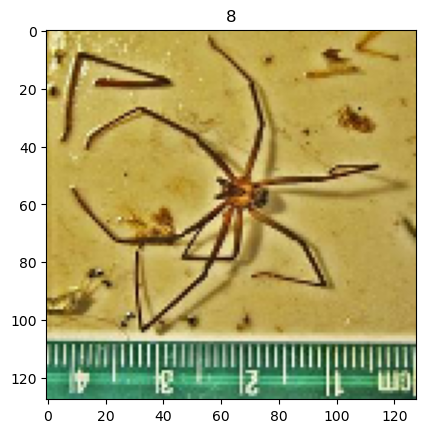

In [9]:
for images, labels in train_ds.take(1):
    plt.imshow(images[0].numpy().astype('uint8'))
    plt.title(labels[0].numpy())
    break

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
train_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
                  'Data/original',
                  target_size=(IMAGE_SIZE, IMAGE_SIZE),
                  batch_size=BATCH_SIZE,
                  shuffle=True,
                  subset='training',
                  class_mode='binary')

val_generator = train_datagen.flow_from_directory(
                  'Data/original',
                  target_size=(IMAGE_SIZE, IMAGE_SIZE),
                  batch_size=BATCH_SIZE,
                  shuffle=True,
                  subset='validation',
                  class_mode='binary')   

Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'


Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


In [13]:
train_generator.class_indices

{'butterfly': 0,
 'cat': 1,
 'chicken': 2,
 'cow': 3,
 'dog': 4,
 'elephant': 5,
 'horse': 6,
 'sheep': 7,
 'spider': 8,
 'squirrel': 9}

In [14]:
def schedule(epoch):
    cycle = 0
    if epoch < (EPOCHS // 2):
        cycle = 1 + (epoch * STEPS_PER_EPOCH) // (EPOCHS // 2)
        factor = float(cycle * MAX_LR) / float(EPOCHS)
    else:
        cycle = 1 + ((EPOCHS - epoch) * STEPS_PER_EPOCH) // (EPOCHS // 2)
        factor = float(cycle * MAX_LR) / float(EPOCHS)
        factor = MAX_LR - factor

    if ANNEAL_STRATEGY == 'cos':
        lr = factor * (1 + tf.math.cos(tf.constant(np.pi) * (epoch % (EPOCHS // 2)) / (EPOCHS // 2))) / 2
    elif ANNEAL_STRATEGY == 'linear':
        lr = factor * (EPOCHS - epoch) / EPOCHS
    else:
        raise ValueError('Invalid anneal strategy')
    
    wandb.log({'learning_rate': lr})

    return lr

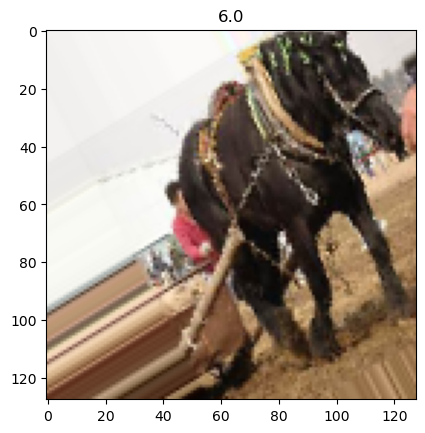

In [15]:
for images, labels in iter(train_generator):
    plt.imshow(images[0])
    plt.title(labels[0])
    break

In [16]:
class WandbCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log(logs)

In [17]:
""" with tf.device('/cpu:0'):
  augment = tf.keras.Sequential([
      layers.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.2)
  ]) """

model = tf.keras.Sequential([
    #augment,

    layers.Conv2D(32, 3, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(32, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(256, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Activation('relu'),
    layers.Dense(10)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
lr_scheduler = LearningRateScheduler(schedule=schedule, verbose=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=0.0001)

metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
    tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)
]

model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 128, 128, 32)      0

Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'


In [18]:
callbacks = [WandbCallback(), 
             EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, restore_best_weights=True), 
             ModelCheckpoint("model_checkpoint.h5", save_best_only=True),
             lr_scheduler
             ]

model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, callbacks=callbacks, class_weight=weights)


Epoch 1: LearningRateScheduler setting learning rate to 5e-05.
Epoch 1/200


2023-04-10 11:27:59.076271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


655/655 [==============================] - ETA: 0s - loss: 1.8187 - sparse_categorical_accuracy: 0.2587 - sparse_categorical_crossentropy: 2.1542

2023-04-10 11:30:02.111515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


655/655 [==============================] - 140s 213ms/step - loss: 1.8187 - sparse_categorical_accuracy: 0.2587 - sparse_categorical_crossentropy: 2.1542 - val_loss: 1.9208 - val_sparse_categorical_accuracy: 0.3318 - val_sparse_categorical_crossentropy: 1.9208 - lr: 5.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 4.975e-05.
Epoch 2/200
655/655 [==============================] - 142s 217ms/step - loss: 1.5623 - sparse_categorical_accuracy: 0.3476 - sparse_categorical_crossentropy: 1.8473 - val_loss: 1.6918 - val_sparse_categorical_accuracy: 0.4142 - val_sparse_categorical_crossentropy: 1.6918 - lr: 4.9750e-05

Epoch 3: LearningRateScheduler setting learning rate to 4.9500000000000004e-05.
Epoch 3/200
655/655 [==============================] - 142s 217ms/step - loss: 1.4495 - sparse_categorical_accuracy: 0.3952 - sparse_categorical_crossentropy: 1.7109 - val_loss: 1.7221 - val_sparse_categorical_accuracy: 0.3924 - val_sparse_categorical_crossentropy: 1.7221 - lr: 4.95

KeyboardInterrupt: 

In [19]:
pd.DataFrame(model.history.history)

,loss,sparse_categorical_accuracy,sparse_categorical_crossentropy,val_loss,val_sparse_categorical_accuracy,val_sparse_categorical_crossentropy,lr
0,1.818719,0.258748,2.154177,1.920816,0.331804,1.920816,0.000050
1,1.562273,0.347639,1.847315,1.691806,0.414182,1.691806,0.000050
2,1.449489,0.395236,1.710872,1.722104,0.392393,1.722104,0.000049
3,1.380268,0.429178,1.627103,1.612056,0.433486,1.612056,0.000049
4,1.333750,0.449563,1.569853,1.548959,0.462538,1.548959,0.000049
5,1.273612,0.473003,1.501194,1.425782,0.513379,1.425782,0.000049
6,1.222645,0.498067,1.443250,1.547026,0.462920,1.547026,0.000048
7,1.189077,0.510813,1.402431,1.476396,0.480313,1.476396,0.000048
8,1.157487,0.527522,1.366952,1.549082,0.469419,1.549082,0.000048
9,1.129705,0.538072,1.333062,1.359710,0.522745,1.359710,0.000048


In [20]:
model.evaluate(val_generator)

164/164 [==============================] - 16s 98ms/step - loss: 0.8734 - sparse_categorical_accuracy: 0.7108 - sparse_categorical_crossentropy: 0.8734


[0.8734358549118042, 0.7108180522918701, 0.8734358549118042]

In [21]:
tf.keras.models.save_model(model, f'model/{name_of_run}.pth')
wandb.save(f'runs/pima_run_{date.today().strftime("%Y-%m-%d")}-{name_of_run}')
wandb.finish()

INFO:tensorflow:Assets written to: model/wider-conv-layers-8-image-generator-penalization-200epoch-scheduler.pth/assets


INFO:tensorflow:Assets written to: model/wider-conv-layers-8-image-generator-penalization-200epoch-scheduler.pth/assets


learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
loss,█▇▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▂▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
sparse_categorical_crossentropy,█▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▆▅▅▄▅▄▅▅▄▄▄▄▃▃▃▃▃▅▃▂▂▃▃▂▂▂▂▂▁▂▂▂▂▁▁▂
val_sparse_categorical_accuracy,▁▂▃▃▃▄▄▅▄▅▅▅▅▅▆▅▆▆▆▆▆▅▆▆▇▆▆▇▇▆▇▇█▇▇▇▇██▇
val_sparse_categorical_crossentropy,█▇▆▆▆▅▅▄▅▄▅▅▄▄▄▄▃▃▃▃▃▅▃▂▂▃▃▂▂▂▂▂▁▂▂▂▂▁▁▂
learning_rate,4e-05
loss,0.6032
sparse_categorical_accuracy,0.75591
sparse_categorical_crossentropy,0.72459


1/1 [==============================] - 0s 12ms/step


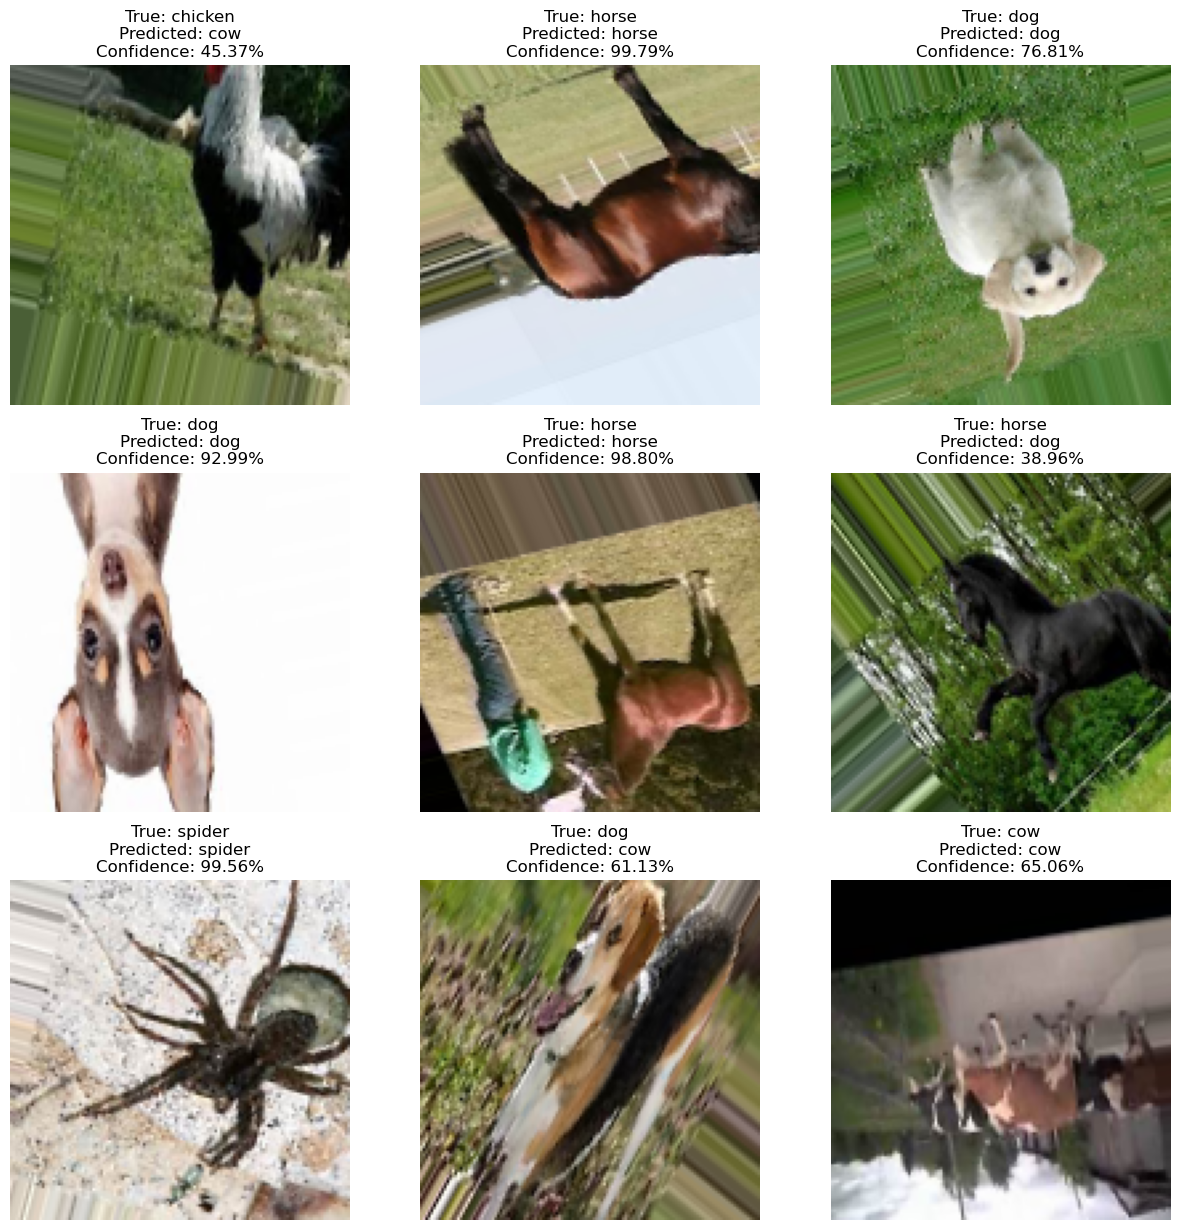

In [41]:
i = 0

plt.figure(figsize=(15, 15))

for image, label in iter(val_generator):
    img_array = tf.keras.utils.img_to_array(image[0])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0])
    plt.title(f'True: {class_names[int(label[0])]}\nPredicted: {class_names[np.argmax(score)]}\nConfidence: {100 * np.max(score):.2f}%')
    plt.axis("off")
    
    i += 1
    if i == 9:
        break